In [2]:
# mandatory xcube store imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.dsio import open_cube
from xcube.core.geom import clip_dataset_by_geometry

# Utilities for notebook visualization.
# JSON provides pretty-printing of Python lists and dictionaries.
from IPython.display import JSON

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray
import shapely
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
#import openeo
import bottleneck
from xcube_cmems.store import CmemsDataStore
import xcube_cmems
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import rasterio
from collections import Counter

In [3]:
# write in your CMEMS username and password
user = "henrikwsp"
pwrd = "DTO_Skagerrak25"

os.environ["CMEMS_USERNAME"] =  user
os.environ["CMEMS_PASSWORD"] = pwrd

In [4]:
# check that "cmems" is an option under root
# if "cmems" is not listed, make sure to install xcube_cmems plugin in the correct env and restart your kernel!
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [5]:
## Trying to list all datastore ids - return to this
cmems_store =  CmemsDataStore()
#cmems_ids = cmems_store.list_data_ids()
#cmems_ids = cmems_store.get_datasets_with_titles()
cmems_store

In [6]:
cmems_store.get_open_data_params_schema("cmems_mod_bal_bgc_anfc_P1D-m")

In [7]:
# create a data store instance as variable
store = new_data_store("cmems")
store

In [8]:
# replace "id" with dataset id from Copernicus Marine
id = 'cmems_mod_bal_bgc_anfc_P1D-m'

# enter start and end dates
start = "2024-07-21"
end = "2024-07-27"

# replace with variables of interest from dataset
# if multiple variables: ['x','y']
# if ALL variable in dataset: []
varbs = ['zsd']

# create bounding box [W,S,E,N]
bbox = [9.5, 55, 13, 60]

ds = store.open_data(
    id,
    variable_names=varbs,
    bbox=bbox,
    time_range=(start, end),
)
ds

WARNING - 2025-05-21T08:16:40Z - Deprecation warning for option 'no_metadata_cache'. This option will no longer be available in copernicusmarine>=2.0.0. Please refer to the documentation when the new major version is released for more information.
Fetching catalog: 100%|██████████| 3/3 [00:14<00:00,  4.85s/it]
INFO - 2025-05-21T08:16:55Z - Dataset version was not specified, the latest one was selected: "202411"
INFO - 2025-05-21T08:16:55Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-05-21T08:16:56Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset> Size: 1MB
Dimensions:    (time: 7, latitude: 300, longitude: 126)
Coordinates:
  * latitude   (latitude) float32 1kB 55.01 55.02 55.04 ... 59.96 59.97 59.99
  * longitude  (longitude) float32 504B 9.514 9.542 9.569 ... 12.93 12.96 12.99
  * time       (time) datetime64[ns] 56B 2024-07-21 2024-07-22 ... 2024-07-27
Data variables:
    zsd        (time, latitude, longitude) float32 1MB ...
Attributes: (12/18)
    Conventions:            CF-1.0
    comment:                Data on cropped native product grid. Horizontal v...
    compression:            yes
    contact:                servicedesk.cmems@mercator-ocean.eu
    creation_date:          2024-11-20 09:24:59
    easternmost_longitude:  30.208656311035156
    ...                     ...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    southernmost_latitude:  53.008296966552734
    start_date:             2024-11-25 12:00:00
    stop_date:              2024-11-25 12:00:00
    title:                  CMEMS ERGOM daily integrated model fields
    westernmost_longitude:  9.041582107543945

In [9]:
# forward-fill the dataset
ds_fill = ds.ffill(dim='time', limit=None)

# remote Time dimension and average for each pixel across time series
ds_mean = ds_fill.mean(dim='time', skipna=True)

# plot the mean data
#ds_mean.o2b.plot()

In [10]:
# in case we want to resample weekly / monthly / etc.

ds_weekly = ds_fill.resample(time='W').mean('time')
ds_weekly

<xarray.Dataset> Size: 304kB
Dimensions:    (time: 2, latitude: 300, longitude: 126)
Coordinates:
  * latitude   (latitude) float32 1kB 55.01 55.02 55.04 ... 59.96 59.97 59.99
  * longitude  (longitude) float32 504B 9.514 9.542 9.569 ... 12.93 12.96 12.99
  * time       (time) datetime64[ns] 16B 2024-07-21 2024-07-28
Data variables:
    zsd        (time, latitude, longitude) float32 302kB nan nan nan ... nan nan
Attributes: (12/18)
    Conventions:            CF-1.0
    comment:                Data on cropped native product grid. Horizontal v...
    compression:            yes
    contact:                servicedesk.cmems@mercator-ocean.eu
    creation_date:          2024-11-20 09:24:59
    easternmost_longitude:  30.208656311035156
    ...                     ...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    southernmost_latitude:  53.008296966552734
    start_date:             2024-11-25 12:00:00
    stop_date:              2024-11-25 12:00:00
    title:                  CMEMS ERGOM daily integrated model fields
    westernmost_longitude:  9.041582107543945

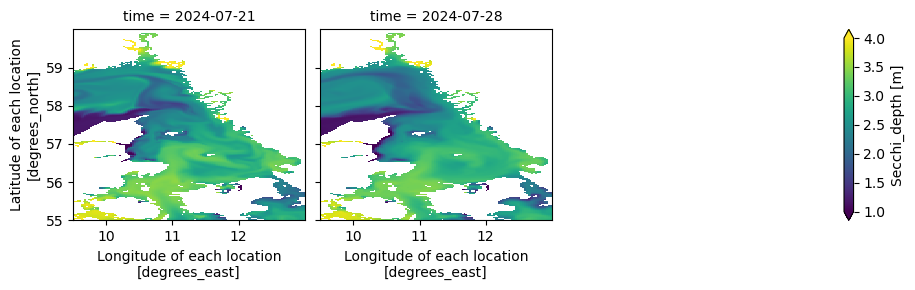

In [11]:
testplot = ds_weekly.zsd.isel(time=slice(0,9)).plot(x='longitude', y='latitude', col='time', col_wrap=3, vmin=1, vmax=4)

In [12]:
# read in kustvattenförekomster and clip to the study area

kvf = os.path.join('external_data', 'VM', 'vm.Kustvatten_Vattenforekomster_2016_1.shp')
kvf = gpd.read_file(kvf)
kvf = kvf.to_crs(4326)

c =  {'NW': [9.5, 60],
      'NE': [13, 60],
      'SW': [9.5, 55],
      'SE': [13, 55]}

bb = Polygon([c['NW'], c['NE'], c['SE'], c['SW']])

kvf_clipped = kvf.clip(bb)
kvf_clipped.plot()

DataSourceError: external_data/VM/vm.Kustvatten_Vattenforekomster_2016_1.shp: No such file or directory

In [ ]:
# check out the geodataframe info
kvf_clipped.info()

In [ ]:
# dissolve kvf by 'TYPOMRKUST'

kvf_dissolved = kvf_clipped.dissolve(by='TYPOMRKUST')
kvf_dissolved = kvf_dissolved.reset_index()

for row in kvf_dissolved.itertuples():
    print(f'Index {row.Index}: TYPOMRKUST <{row.TYPOMRKUST}>')

In [ ]:
ds_mean = ds_mean.rio.write_crs(4326)
ds_mclipped=[]
for index, row in kvf_dissolved.iterrows():
    aoi = ds_mean.rio.clip([row['geometry']], all_touched=True)
    ds_mclipped.append(aoi)

In [ ]:

for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]
    fig, ax = plt.subplots(figsize=(8, 6))
    data['zsd'].plot(ax=ax,vmin=1, vmax=4)

    kvf_dissolved.iloc[[ind]].boundary.plot(ax=ax, edgecolor="black")

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"

    ax.set_title(f"Secchi depth - {area_name}", fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()
    

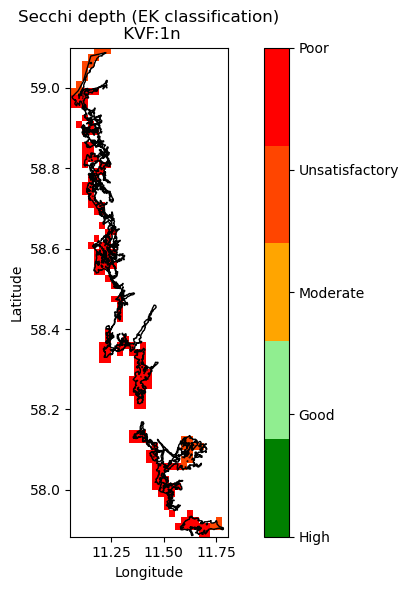

,Class,Pixel count,Share (%)
,Poor,150,85.7
,Unsatisfactory,25,14.3


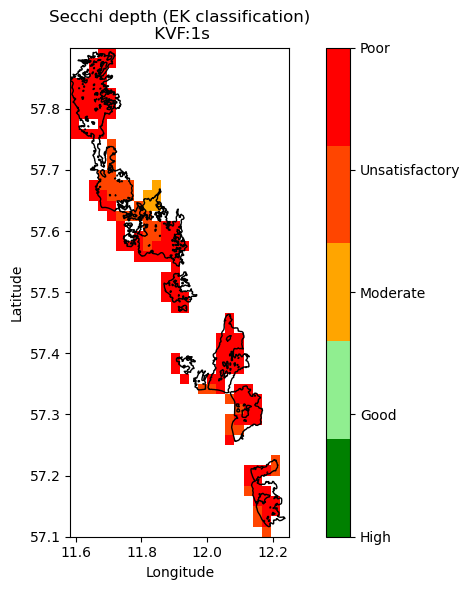

,Class,Pixel count,Share (%)
,Unsatisfactory,35,23.2
,Poor,111,73.5
,Moderate,5,3.3


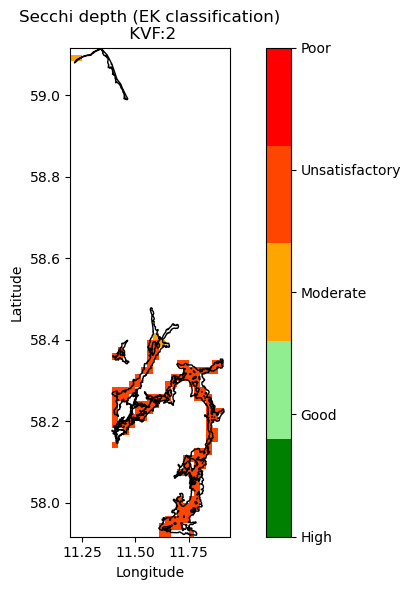

,Class,Pixel count,Share (%)
,Unsatisfactory,122,96.8
,Moderate,4,3.2


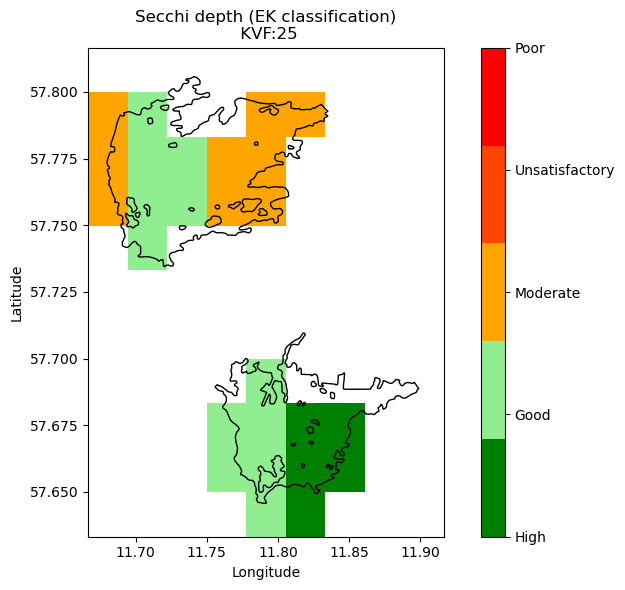

,Class,Pixel count,Share (%)
,Good,12,46.2
,High,5,19.2
,Moderate,9,34.6


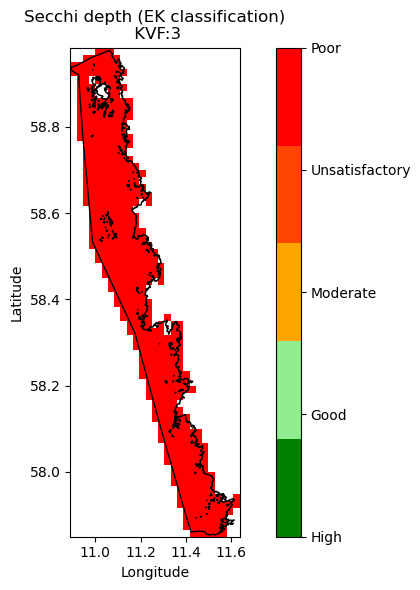

,Class,Pixel count,Share (%)
,Poor,512,100.0


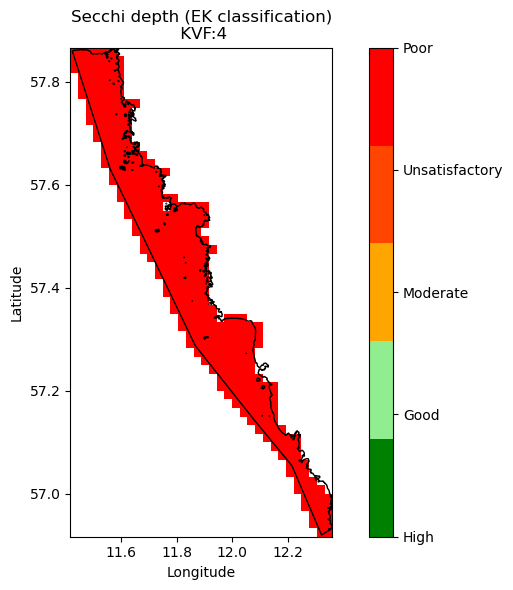

,Class,Pixel count,Share (%)
,Poor,359,100.0


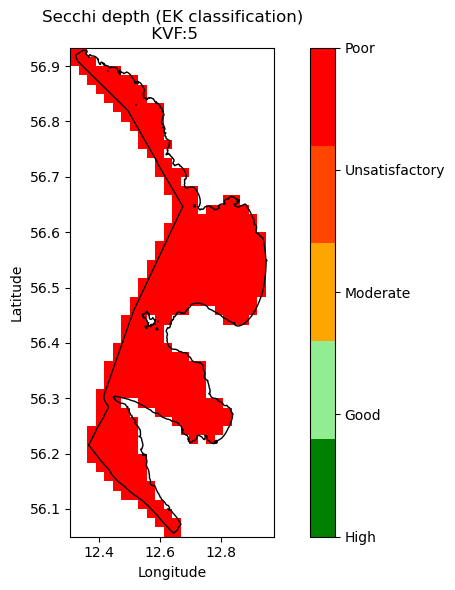

,Class,Pixel count,Share (%)
,Poor,404,100.0


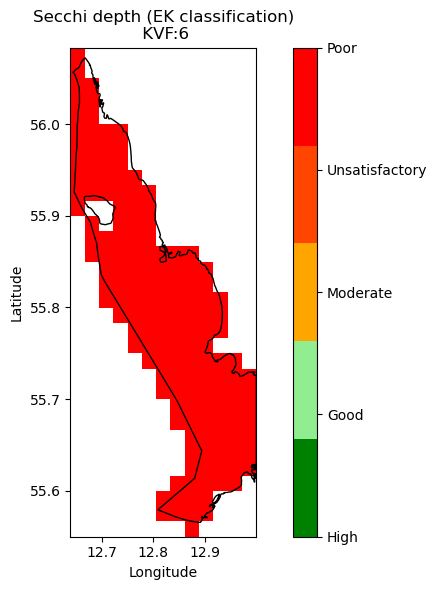

,Class,Pixel count,Share (%)
,Poor,160,100.0


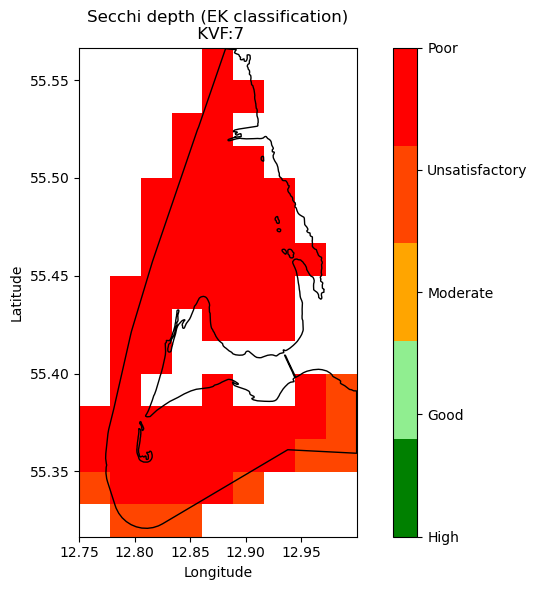

,Class,Pixel count,Share (%)
,Unsatisfactory,9,13.2
,Poor,59,86.8


In [18]:
# EK-tabell
ek_table = [
    {"Typ": "1n", "Rv": 10.5, "HG": 0.81, "GM": 0.67, "MO": 0.48, "OD": 0.29},
    {"Typ": "1s", "Rv": 8,    "HG": 0.81, "GM": 0.69, "MO": 0.50, "OD": 0.38},
    {"Typ": "2", "Rv": 8,    "HG": 0.81, "GM": 0.63, "MO": 0.44, "OD": 0.31},
    {"Typ": "3",  "Rv": 12,   "HG": 0.83, "GM": 0.67, "MO": 0.42, "OD": 0.29},
    {"Typ": "25", "Rv": 4.5,  "HG": 0.89, "GM": 0.67, "MO": 0.45, "OD": 0.11},
    {"Typ": "4",  "Rv": 10.5, "HG": 0.9, "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "5",  "Rv": 10.5, "HG": 0.90, "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "6",  "Rv": 10.0, "HG": 0.90, "GM": 0.75, "MO": 0.45, "OD": 0.30},
    {"Typ": "7",  "Rv": 10.0, "HG": 0.83, "GM": 0.70, "MO": 0.40, "OD": 0.20},
]

# Gör dictionary
ek_dict = {row["Typ"]: row for row in ek_table}

# Klassfärger
class_colors = {
    "High": "green",
    "Good": "lightgreen",
    "Moderate": "orange",
    "Unsatisfactory": "orangered",
    "Poor": "red"
}
class_to_int = {k: i for i, k in enumerate(class_colors.keys())}
int_to_class = list(class_colors.keys())

results = []

for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]

    try:
        typ = str(kvf_dissolved.iloc[ind]['TYPOMRKUST']).strip()
        thresholds = ek_dict[typ]
        ref = thresholds["Rv"]
    except KeyError:
        continue

    # Beräkna EK
    zsd_values = data['zsd'].values
    ek_values = zsd_values / ref
    valid_mask = ~np.isnan(zsd_values)

    classification_array = np.full_like(zsd_values, np.nan)

    for i in range(zsd_values.shape[0]):
        for j in range(zsd_values.shape[1]):
            if valid_mask[i, j]:
                val = ek_values[i, j]
                if val >= thresholds["HG"]:
                    classification_array[i, j] = class_to_int["High"]
                elif val >= thresholds["GM"]:
                    classification_array[i, j] = class_to_int["Good"]
                elif val >= thresholds["MO"]:
                    classification_array[i, j] = class_to_int["Moderate"]
                elif val >= thresholds["OD"]:
                    classification_array[i, j] = class_to_int["Unsatisfactory"]
                else:
                    classification_array[i, j] = class_to_int["Poor"]

    # Konvertera till xarray.DataArray med originalkoordinater
    class_da = xr.DataArray(
        classification_array,
        coords=data['zsd'].coords,
        dims=data['zsd'].dims
    )

    # Plot med plot(), inte imshow
    cmap = ListedColormap([class_colors[c] for c in int_to_class])
    cmap.set_bad('white')
    norm = plt.Normalize(vmin=0, vmax=len(class_to_int) - 1)

    try:
        area_name = kvf_dissolved.iloc[ind]['TYPOMRKUST']
    except:
        area_name = f"Area {ind}"

    fig, ax = plt.subplots(figsize=(8, 6))
    class_da.plot(ax=ax, cmap=cmap, norm=norm)
    kvf_dissolved.iloc[[ind]].plot(ax=ax, edgecolor='black', facecolor='none')
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(len(int_to_class)))
    cbar.set_ticklabels(int_to_class)

    ax.set_title(f"Secchi depth (EK classification)\n KVF:{area_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()

    # Flatten the classification array and exclude NaN values
    flat_array = classification_array[~np.isnan(classification_array)].astype(int).ravel()
    total_pixels = len(flat_array)
    
    # Count number of pixels per class
    counts = Counter(flat_array)
    
    # Create list of rows with class name, pixel count, and percentage
    pixel_stats = []
    for class_index, count in counts.items():
        class_name = int_to_class[class_index]
        percentage = 100 * count / total_pixels
        pixel_stats.append([class_name, count, round(percentage, 1)])
    
    # Create and display the DataFrame without index
    pixel_df = pd.DataFrame(pixel_stats, columns=["Class", "Pixel count", "Share (%)"])
    pixel_df.index = [''] * len(pixel_df)  # Remove index
    display(pixel_df)

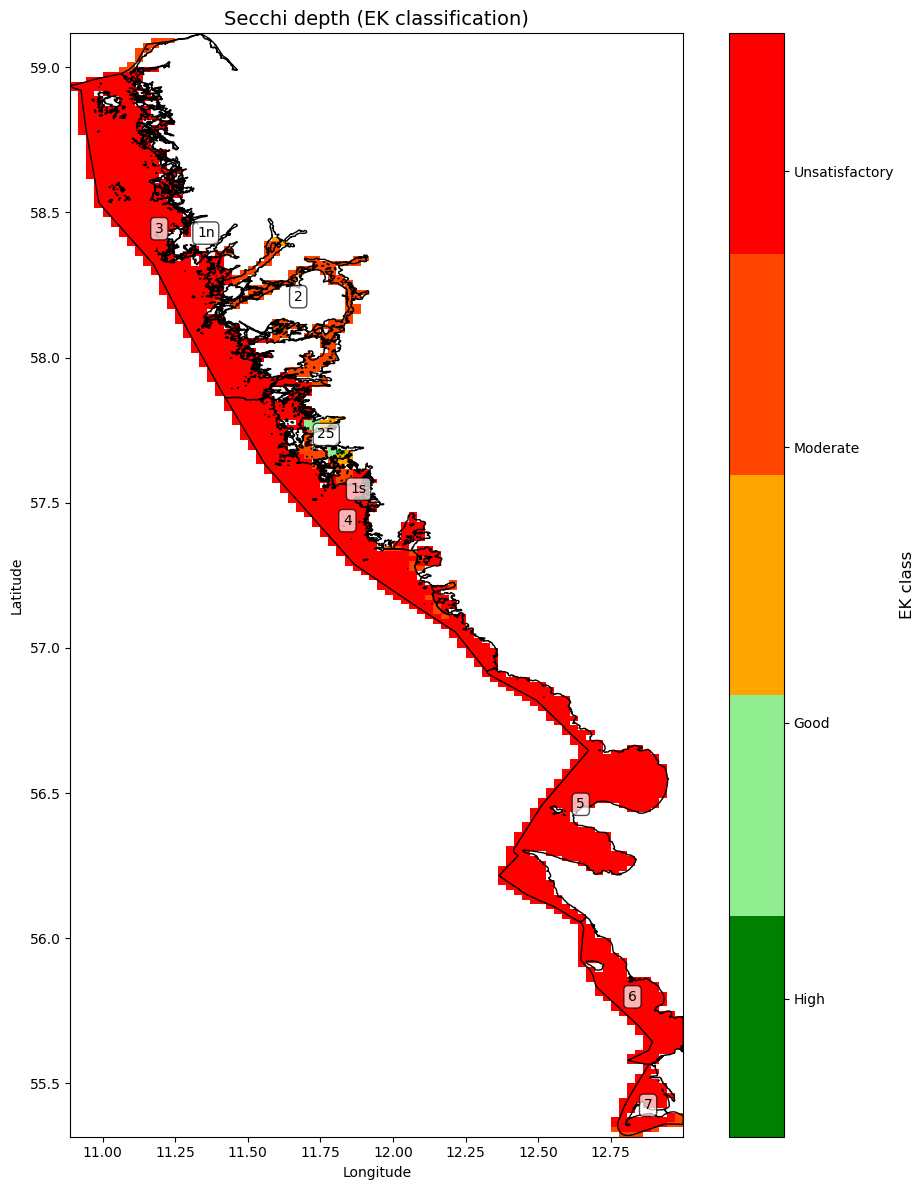

In [17]:
# EK-table from VISS
ek_table = [
    {"Typ": "1n", "Rv": 10.5, "HG": 0.81, "GM": 0.67, "MO": 0.48, "OD": 0.29},
    {"Typ": "1s", "Rv": 8,    "HG": 0.81, "GM": 0.69, "MO": 0.50, "OD": 0.38},
    {"Typ": "2", "Rv": 8,    "HG": 0.81, "GM": 0.63, "MO": 0.44, "OD": 0.31},
    {"Typ": "3",  "Rv": 12,   "HG": 0.83, "GM": 0.67, "MO": 0.42, "OD": 0.29},
    {"Typ": "25", "Rv": 4.5,  "HG": 0.89, "GM": 0.67, "MO": 0.45, "OD": 0.11},
    {"Typ": "4",  "Rv": 10.5, "HG": 0.9, "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "5",  "Rv": 10.5, "HG": 0.90, "GM": 0.76, "MO": 0.48, "OD": 0.33},
    {"Typ": "6",  "Rv": 10.0, "HG": 0.90, "GM": 0.75, "MO": 0.45, "OD": 0.30},
    {"Typ": "7",  "Rv": 10.0, "HG": 0.83, "GM": 0.70, "MO": 0.40, "OD": 0.20},
]
ek_dict = {row["Typ"]: row for row in ek_table}

#classification colors
class_colors = {
    "High": "green",
    "Good": "lightgreen",
    "Moderate": "orange",
    "Unsatisfactory": "orangered",
    "Poor": "red"
}
class_to_int = {k: i for i, k in enumerate(class_colors.keys())}
int_to_class = list(class_colors.keys())

combined_array = None
all_flat = []

for ind in range(len(ds_mclipped)):
    data = ds_mclipped[ind]

    try:
        typ = str(kvf_dissolved.iloc[ind]['TYPOMRKUST']).strip()
        thresholds = ek_dict[typ]
        ref = thresholds["Rv"]
    except KeyError:
        continue

    zsd_values = data['zsd'].values
    ek_values = zsd_values / ref
    valid_mask = ~np.isnan(zsd_values)

    classification_array = np.full_like(zsd_values, np.nan)
    for i in range(zsd_values.shape[0]):
        for j in range(zsd_values.shape[1]):
            if valid_mask[i, j]:
                val = ek_values[i, j]
                if val > thresholds["HG"]:
                    classification_array[i, j] = class_to_int["High"]
                elif val > thresholds["GM"]:
                    classification_array[i, j] = class_to_int["Good"]
                elif val > thresholds["MO"]:
                    classification_array[i, j] = class_to_int["Moderate"]
                elif val > thresholds["OD"]:
                    classification_array[i, j] = class_to_int["Unsatisfactory"]
                else:
                    classification_array[i, j] = class_to_int["Poor"]

    class_da = xr.DataArray(
        classification_array,
        coords=data['zsd'].coords,
        dims=data['zsd'].dims
    )

    # combine classification
    if combined_array is None:
        combined_array = class_da
    else:
        combined_array = combined_array.combine_first(class_da)

class_da = xr.DataArray(combined_array, coords=combined_array.coords, dims=combined_array.dims, name="zsd_class")
class_da.attrs['long_name']='Secchi depth classification (EK)'
class_da.attrs['units']='class'
# Colors and normalization
cmap = ListedColormap([class_colors[c] for c in int_to_class])
cmap.set_bad('white')
norm = plt.Normalize(vmin=0, vmax=len(int_to_class) - 1)

fig, ax = plt.subplots(figsize=(10, 12))

img = combined_array.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

cbar = fig.colorbar(img, ax=ax, ticks=np.arange(len(int_to_class)) + 0.5)
cbar.ax.set_yticklabels(int_to_class)
cbar.set_label("EK class", fontsize=12)

# kvf areas
kvf_dissolved.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# labels
for idx, row in kvf_dissolved.iterrows():
    centroid = row.geometry.centroid
    label = str(row['TYPOMRKUST'])
    ax.text(
        centroid.x, centroid.y, label,
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.7)
    )
ax.set_title("Secchi depth (EK classification)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()